
Import Libraries and Check CUDA Availability
---



In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import ast
import torch.utils.data as data
from collections import defaultdict, Counter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Configuration and Label Mapping
---





In [2]:
# Training parameters
num_classes = 36
num_sensors = 5
sequence_length = 20
batch_size = 32
train_loop_enable =1
    
# Label mapping
label_map = {i * 10 + j: index for index, (i, j) in enumerate(((i, j) for i in range(1, 10) for j in range(1, 5)))}
index_to_label = {index: label for label, index in label_map.items()}

def label_to_index(labels):
    # Map sequences of labels to indices
    return torch.tensor([[label_map[lbl.item()] for lbl in label_seq] for label_seq in labels], dtype=torch.long)

def index_to_label_func(index):
    return index_to_label[index]

print(label_map)

{11: 0, 12: 1, 13: 2, 14: 3, 21: 4, 22: 5, 23: 6, 24: 7, 31: 8, 32: 9, 33: 10, 34: 11, 41: 12, 42: 13, 43: 14, 44: 15, 51: 16, 52: 17, 53: 18, 54: 19, 61: 20, 62: 21, 63: 22, 64: 23, 71: 24, 72: 25, 73: 26, 74: 27, 81: 28, 82: 29, 83: 30, 84: 31, 91: 32, 92: 33, 93: 34, 94: 35}


label_to_xy func
---

In [3]:
# Khu vực chứa các nhãn
area = [
    [11, 12, 21, 22, 31, 32],
    [13, 14, 23, 24, 33, 34],
    [41, 42, 51, 52, 61, 62],
    [43, 44, 53, 54, 63, 64],
    [71, 72, 81, 82, 91, 92],
    [73, 74, 83, 84, 93, 94]
]

# Hàm chuyển đổi từ nhãn sang tọa độ (x, y) dựa trên area
# Hàm chuyển đổi từ nhãn sang tọa độ (x, y) dựa trên area
def label_to_xy(label, area):
    # Duyệt qua từng hàng và cột trong area
    for i, row in enumerate(area):
        for j, cell in enumerate(row):
            if cell == label:
                # Tọa độ x tăng từ trái sang phải, cách nhau 0.5
                x = j * 0.5 + 0.25
                # Tọa độ y tăng từ dưới lên trên, cách nhau 0.5
                y = (len(area) - i - 1) * 0.5 + 0.25
                return x, y
    # Nếu không tìm thấy nhãn, trả về None
    return None

In [4]:
def check_nan_inf(array, name="array"):
    try:
        # Chuyển đổi mảng sang kiểu float nếu có thể
        array = np.array(array, dtype=np.float64)
    except ValueError:
        print(f"{name} chứa giá trị không phải số, bỏ qua.")
        return False

    # Kiểm tra NaN và Inf
    if np.isnan(array).any():
        print(f"{name} chứa NaN.")
        return False
    if np.isinf(array).any():
        print(f"{name} chứa Inf.")
        return False

    return True


Import from csv
---



In [5]:
import os
import numpy as np
import pandas as pd
import torch

# Đường dẫn thư mục chính
base_dir = "./mung_data/1812"

# Đảm bảo chiều dài x và y là 700
target_length = 700

padding_x = 0
offset_x_value=1500

batch_name = []

# Khởi tạo danh sách lưu dữ liệu từ các thư mục cấp 1
x_data = []
y_data = []
y_xy_data = []
time_step_data = []



# Tạo danh sách các thư mục cấp 1
level_1_dirs = sorted([d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))])

for l1_idx, l1_dir in enumerate(level_1_dirs):
    l1_path = os.path.join(base_dir, l1_dir)
    print(f"Đang xử lý thư mục cấp 1: {l1_dir}")

    # Xử lý thư mục cấp 2
    level_2_dirs = sorted([d for d in os.listdir(l1_path) if os.path.isdir(os.path.join(l1_path, d))])

    for l2_idx, l2_dir in enumerate(level_2_dirs):
        l2_path = os.path.join(l1_path, l2_dir)
        print(f"  Đang xử lý thư mục cấp 2: {l2_dir}")

        # Duyệt qua các file CSV trong thư mục cấp 2
        csv_files = sorted([f for f in os.listdir(l2_path) if f.endswith(".csv")])
        i = 0
        for file in csv_files:
            file_path = os.path.join(l2_path, file)
            print(f"    Đang xử lý file CSV: {file}")

            # Đọc và xử lý file CSV
            try:
                data = pd.read_csv(file_path, header=None)
                if data.empty:
                    print(f'    File {file} trống, bỏ qua.')
                    continue

                # Danh sách lưu dòng hợp lệ
                valid_x = []
                valid_y = []
                valid_y_xy = []
                valid_time_step = []

                # Duyệt qua từng dòng của file
                for idx, row in data.iterrows():
                    try:
                        # Lấy giá trị x và y từ dòng
                        x = row[1:6].values - offset_x_value  # 5 cột
                        y = row[6]  # Nhãn
                        time_step = row[0]

                        # Chuyển đổi nhãn nếu cần
                        if isinstance(y, str) and y.startswith('id'):
                            try:
                                # Lấy phần số sau 'id'
                                num_part = int(y[2:])
                                if num_part != 0:
                                    y = int(num_part)  # Chuyển thành số thực
                                    y_xy = label_to_xy(y, area)
                                else:
                                    continue
                            except ValueError:
                                print(f"    Nhãn '{y}' không thể chuyển đổi, bỏ qua.")
                                continue

                        # Loại bỏ dòng nếu y vẫn không hợp lệ
                        if pd.isna(y):
                            print(f"    Dòng {idx} không hợp lệ, bỏ qua.")
                            continue

                        # Kiểm tra NaN và Inf
                        if not check_nan_inf(x, name=f"x (dòng {idx})") or not check_nan_inf(y, name=f"y (dòng {idx})"):
                            print(f"    Bỏ qua dòng {idx} do chứa giá trị không hợp lệ.")
                            continue
                        if not check_nan_inf(time_step, name=f"time_step (dòng {idx})"):
                            print(f"    Bỏ qua dòng {idx} do chứa giá trị không hợp lệ.")
                            continue
                        # Lưu dòng hợp lệ
                        valid_x.append(x)
                        valid_y.append(y)
                        valid_y_xy.append(y_xy)
                        valid_time_step.append(int(time_step))

                        i += 1
                        batch_name.append(f"{l1_dir}_{l2_dir}_file{i}")

                    except Exception as e:
                        print(f"    Lỗi khi xử lý dòng {idx}: {e}")

                # Chuyển danh sách thành numpy array
                valid_x = np.array(valid_x).T
                valid_y = np.array(valid_y).T
                valid_y_xy = np.array(valid_y_xy).T
                valid_time_step = np.array(valid_time_step).T

                # Thêm vào danh sách cấp 2
                x_data.append(valid_x)
                y_data.append(valid_y)
                y_xy_data.append(valid_y_xy)
                time_step_data.append(valid_time_step)

            except Exception as e:
                print(f"Lỗi khi xử lý file {file_path}: {e}")


Đang xử lý thư mục cấp 1: bt
  Đang xử lý thư mục cấp 2: cot1
    Đang xử lý file CSV: 1734510152055-1734510164061.csv
    Đang xử lý file CSV: 1734510180107-1734510193637.csv
    Đang xử lý file CSV: 1734510204347-1734510218468.csv
    Đang xử lý file CSV: 1734510296756-1734510308351.csv
    Đang xử lý file CSV: 1734510324433-1734510337669.csv
    Đang xử lý file CSV: 1734510350169-1734510363282.csv
    Đang xử lý file CSV: 1734510450167-1734510463020.csv
    Đang xử lý file CSV: 1734510503025-1734510516546.csv
    Đang xử lý file CSV: 1734510529190-1734510543907.csv
    Đang xử lý file CSV: 1734510570527-1734510583482.csv
  Đang xử lý thư mục cấp 2: cot2
    Đang xử lý file CSV: 1734510633205-1734510646416.csv
    Đang xử lý file CSV: 1734510684124-1734510698505.csv
    Đang xử lý file CSV: 1734510713815-1734510728342.csv
    Đang xử lý file CSV: 1734510756020-1734510769337.csv
    Đang xử lý file CSV: 1734510787204-1734510800890.csv
    Đang xử lý file CSV: 1734510840924-17345108553


Noise filter func
---



In [6]:
import numpy as np
import scipy.signal as signal

def noise_filter(x, fs=100, fc=3.5):
    """
    Lọc thông thấp để giảm nhiễu tín hiệu.
    
    Parameters:
        x (numpy.ndarray): Tín hiệu đầu vào, mảng 2D với mỗi hàng là một chuỗi tín hiệu.
        fs (int): Tần số lấy mẫu (Hz). Mặc định là 100 Hz.
        fc (float): Tần số cắt (Hz). Mặc định là 3.5 Hz.
        
    Returns:
        numpy.ndarray: Tín hiệu sau khi lọc nhiễu, có cùng kích thước với x.
    """
    # Tạo bộ lọc Butterworth
    b, a = signal.butter(N=4, Wn=fc / (fs / 2), btype='low')  # Bộ lọc Butterworth bậc 4
    
    # Áp dụng bộ lọc thông thấp
    x_filtered = []
    for row in x:
        # Kiểm tra nếu row là một mảng NumPy hoặc danh sách
        if isinstance(row, (np.ndarray, list)) and np.ndim(row) == 1:
            if len(row) > 0:  # Chỉ xử lý nếu hàng không rỗng
                filtered_row = signal.filtfilt(b, a, row)  # Lọc tín hiệu
                x_filtered.append(filtered_row)
            else:
                x_filtered.append(np.array([]))  # Giữ nguyên nếu rỗng
        else:
            # Xử lý khi row không phải là mảng 1D
            print(f"Cảnh báo: Bỏ qua hàng không hợp lệ ({type(row)})")
            x_filtered.append(np.array([]))
    return np.array(x_filtered, dtype=object)  # Trả về mảng object để tránh lỗi định dạng
filtered_x_data=[]
for i in range(len(x_data)):
    filtered_x_data.append(noise_filter(x_data[i]))
print("da loc x_data")
x_data=filtered_x_data

da loc x_data



Cut data
---



In [7]:
import numpy as np
import torch

# Khởi tạo danh sách cho dữ liệu cắt
x_data_cut = []
y_data_cut = []
step = 20

# Cắt dữ liệu
# for i in range(len(x_data)):
for i in range(len(x_data)):
    num_slices = len(y_data[i]) // step  # Tính số lần cắt tối đa
    for j in range(num_slices):
        start_cut = j * step
        end_cut = start_cut + step

        # Cắt dữ liệu cho x và y
        x_cut = [x_data[i][k][start_cut:end_cut] for k in range(5)]  # 5 đặc trưng (cột)
        y_cut = y_data[i][start_cut:end_cut]

        # Kiểm tra dữ liệu hợp lệ
        if len(y_cut) == step and all(len(feature) == step for feature in x_cut):
            x_data_cut.append(np.array(x_cut))  # Đảm bảo thành mảng numpy
            y_data_cut.append(np.array(y_cut))  # Đảm bảo thành mảng numpy

# Thêm kiểm tra chi tiết kích thước
print("Kiểm tra kích thước các phần tử trước khi stack:")
x_shapes = [arr.shape for arr in x_data_cut]
y_shapes = [arr.shape for arr in y_data_cut]

print(f"Kích thước các phần tử x_data_cut: {set(x_shapes)}")
print(f"Kích thước các phần tử y_data_cut: {set(y_shapes)}")

# Nếu có kích thước không đồng nhất, in chi tiết phần tử gây lỗi
if len(set(x_shapes)) > 1 or len(set(y_shapes)) > 1:
    print("Phát hiện các phần tử không đồng nhất:")
    for idx, shape in enumerate(x_shapes):
        if shape != x_shapes[0]:
            print(f"x_data_cut[{idx}] có kích thước không đồng nhất: {shape}")
    for idx, shape in enumerate(y_shapes):
        if shape != y_shapes[0]:
            print(f"y_data_cut[{idx}] có kích thước không đồng nhất: {shape}")
    raise ValueError("Các phần tử trong x_data_cut hoặc y_data_cut không đồng nhất!")

# Chuyển đổi x_data_cut và y_data_cut về numpy arrays với dtype=float
x_data_cut = np.array(x_data_cut, dtype=float)  # Đảm bảo tất cả phần tử là float
y_data_cut = np.array(y_data_cut, dtype=float)  # Tương tự

Kiểm tra kích thước các phần tử trước khi stack:
Kích thước các phần tử x_data_cut: {(5, 20)}
Kích thước các phần tử y_data_cut: {(20,)}



Z-score normalization func
---



In [8]:
# Chuẩn hóa Z-Score
def z_score(x_data_cut,d=2, epsilon = 1e-8):
    x_mean = np.mean(x_data_cut, axis=(0, d), keepdims=True)  # Tính giá trị trung bình cho từng đặc trưng
    x_std = np.std(x_data_cut, axis=(0, d), keepdims=True)    # Tính độ lệch chuẩn cho từng đặc trưng
    
    x_data_cut_standardized = (x_data_cut - x_mean) / (x_std + epsilon)
    
    # print(f"Chuẩn hóa Z-Score, kích thước x_tensor: {x_tensor.shape}")
    return x_data_cut_standardized



Tranform to tensor
---



In [9]:
# Chuyển đổi sang PyTorch tensors
# x_tensor = torch.tensor(z_score(x_data_cut), dtype=torch.float32)  # Kích thước: (số lát cắt, 5, step) model v1 chuan hoa x_data
# print(f"Chuẩn hóa Z-Score, kích thước x_tensor: {x_tensor.shape}")

# Chuyển đổi sang PyTorch tensors
try:
    x_tensor = torch.tensor(x_data_cut, dtype=torch.float32)
    y_tensor = torch.tensor(y_data_cut, dtype=torch.float32)
    # y_xy_tensor = torch.tensor(y_xy_data_cut, dtype=torch.float32)
except Exception as e:
    print("Lỗi khi chuyển đổi numpy array sang PyTorch tensor:")
    print(e)
    raise

# Kiểm tra kết quả
print(f"Kích thước x_tensor: {x_tensor.shape}")
print(f"Kích thước y_tensor: {y_tensor.shape}")
# print(f"Kích thước y_xy_tensor: {y_xy_tensor.shape}")



Kích thước x_tensor: torch.Size([15459, 5, 20])
Kích thước y_tensor: torch.Size([15459, 20])



Cut and tranform to tensor (v2)
---



In [10]:
import numpy as np
import torch
import numpy as np
import torch

# Khởi tạo danh sách cho dữ liệu cắt
x_data_cut = []
y_data_cut = []
y_xy_data_cut = []
time_step_data_cut = [] #--------------------------------------------------------
step = sequence_length

# Cắt dữ liệu
for i in range(len(x_data)):
    num_slices = len(y_data[i]) // step  # Tính số lần cắt tối đa
    for j in range(num_slices):
        start_cut = j * step
        end_cut = start_cut + step

        # Cắt dữ liệu cho x và y
        x_cut = [x_data[i][k][start_cut:end_cut] for k in range(5)]  # 5 đặc trưng (cột)
        y_cut = y_data[i][start_cut:end_cut]

        y_xy_cut = [y_xy_data[i][k][start_cut:end_cut] for k in range(2)]  # 2 toa do (cột)
        time_step_cut = time_step_data[i][start_cut:end_cut] #--------------------------------------------------------

        # Kiểm tra dữ liệu hợp lệ
        if len(y_cut) == step and all(len(feature) == step for feature in x_cut):
            # Append data, ensuring it's stored as numpy arrays with dtype uint64
            x_data_cut.append(np.array(x_cut))  # Ensure x_cut is a numpy array
            y_data_cut.append(np.array(y_cut, dtype=np.uint64))  # Explicitly set dtype to uint64
            y_xy_data_cut.append(np.array(y_xy_cut))  # Ensure y_xy_cut is a numpy array
            time_step_data_cut.append(np.array(time_step_cut, dtype=np.uint64))  # Explicitly set dtype to uint64#--------------------------------------------------------


# Kiểm tra kích thước dữ liệu chi tiết
print("Kiểm tra kích thước các phần tử trước khi stack:")
x_shapes = [arr.shape for arr in x_data_cut]
y_shapes = [arr.shape for arr in y_data_cut]
y_xy_shapes = [arr.shape for arr in y_xy_data_cut]
time_step_shapes = [arr.shape for arr in time_step_data_cut]#--------------------------------------------------------

# Sử dụng Counter để đếm các kích thước khác nhau
from collections import Counter
print(f"Kích thước x_data_cut: {Counter(x_shapes)}")
print(f"Kích thước y_data_cut: {Counter(y_shapes)}")
print(f"Kích thước y_xy_data_cut: {Counter(y_xy_shapes)}")
print(f"Kích thước time_step_cut: {Counter(time_step_shapes)}")#--------------------------------------------------------

# Phát hiện các phần tử không đồng nhất
# if len(set(x_shapes)) > 1 or len(set(y_shapes)) > 1 or len(set(y_xy_shapes)) > 1:
if len(set(x_shapes)) > 1 or len(set(y_shapes)) > 1 or len(set(y_xy_shapes)) > 1 or len(set(time_step_shapes)) > 1:
    print("Phát hiện các phần tử không đồng nhất:")
    for idx, shape in enumerate(x_shapes):
        if shape != x_shapes[0]:
            print(f"x_data_cut[{idx}] có kích thước không đồng nhất: {shape}")
    for idx, shape in enumerate(y_shapes):
        if shape != y_shapes[0]:
            print(f"y_data_cut[{idx}] có kích thước không đồng nhất: {shape}")
    for idx, shape in enumerate(y_xy_shapes):
        if shape != y_xy_shapes[0]:
            print(f"y_xy_data_cut[{idx}] có kích thước không đồng nhất: {shape}")
    for idx, shape in enumerate(time_step_shapes):#--------------------------------------------------------
        if shape != time_step_shapes[0]:#--------------------------------------------------------
            print(f"time_step_cut[{idx}] có kích thước không đồng nhất: {shape}")#--------------------------------------------------------
    raise ValueError("Các phần tử trong x_data_cut hoặc y_data_cut hoặc y_xy_data_cut hoặc time_step_data_cut không đồng nhất!")

# Chuyển đổi x_data_cut, y_data_cut, và y_xy_data_cut thành numpy arrays
try:
    x_data_cut = np.array(x_data_cut, dtype=float)
    y_data_cut = np.array(y_data_cut, dtype=np.uint64)
    y_xy_data_cut = np.array(y_xy_data_cut, dtype=float)
    time_step_data_cut = np.array(time_step_data_cut, dtype=np.uint64)#--------------------------------------------------------
except Exception as e:
    print("Lỗi khi chuyển đổi dữ liệu sang numpy array:")
    print(e)
    raise

# Chuyển đổi sang PyTorch tensors
try:
    x_tensor = torch.tensor(x_data_cut, dtype=torch.float32)
    y_tensor = torch.tensor(y_data_cut, dtype=torch.int64)
    y_xy_tensor = torch.tensor(y_xy_data_cut, dtype=torch.float32)
    time_step_tensor = torch.tensor(time_step_data_cut, dtype=torch.int64)#--------------------------------------------------------
except Exception as e:
    print("Lỗi khi chuyển đổi numpy array sang PyTorch tensor:")
    print(e)
    raise

# Kiểm tra kết quả
print(f"Kích thước x_tensor: {x_tensor.shape}")
print(f"Kích thước y_tensor: {y_tensor.shape}")
print(f"Kích thước y_xy_tensor: {y_xy_tensor.shape}")
print(f"Kích thước time_step_tensor: {time_step_tensor.shape}")#--------------------------------------------------------


Kiểm tra kích thước các phần tử trước khi stack:
Kích thước x_data_cut: Counter({(5, 20): 15459})
Kích thước y_data_cut: Counter({(20,): 15459})
Kích thước y_xy_data_cut: Counter({(2, 20): 15459})
Kích thước time_step_cut: Counter({(20,): 15459})
Kích thước x_tensor: torch.Size([15459, 5, 20])
Kích thước y_tensor: torch.Size([15459, 20])
Kích thước y_xy_tensor: torch.Size([15459, 2, 20])
Kích thước time_step_tensor: torch.Size([15459, 20])


In [11]:
time_step_tensor

tensor([[1734510154556, 1734510154566, 1734510154576,  ...,
         1734510154726, 1734510154736, 1734510154746],
        [1734510154756, 1734510154766, 1734510154776,  ...,
         1734510154926, 1734510154936, 1734510154946],
        [1734510154956, 1734510154966, 1734510154976,  ...,
         1734510155126, 1734510155136, 1734510155146],
        ...,
        [1734510007406, 1734510007416, 1734510007426,  ...,
         1734510007576, 1734510007586, 1734510007596],
        [1734510007606, 1734510007616, 1734510007626,  ...,
         1734510007776, 1734510007786, 1734510007796],
        [1734510007806, 1734510007816, 1734510007826,  ...,
         1734510007976, 1734510007986, 1734510007996]])


Import Dataset
---



In [12]:

X_train = x_tensor.to(device)  # Stack them into a tensor and move to the device
Y_train = y_tensor.to(device)  # Stack the labels into a tensor and move to the device
TIMESTEP = time_step_tensor.to(device)  # Stack the labels into a tensor and move to the device #----------------------------


# Verify data shapes
print("Kích thước của x_train:", X_train.shape)
print("Kích thước của y_train:", Y_train.shape)


Kích thước của x_train: torch.Size([15459, 5, 20])
Kích thước của y_train: torch.Size([15459, 20])


In [13]:
TIMESTEP

tensor([[1734510154556, 1734510154566, 1734510154576,  ...,
         1734510154726, 1734510154736, 1734510154746],
        [1734510154756, 1734510154766, 1734510154776,  ...,
         1734510154926, 1734510154936, 1734510154946],
        [1734510154956, 1734510154966, 1734510154976,  ...,
         1734510155126, 1734510155136, 1734510155146],
        ...,
        [1734510007406, 1734510007416, 1734510007426,  ...,
         1734510007576, 1734510007586, 1734510007596],
        [1734510007606, 1734510007616, 1734510007626,  ...,
         1734510007776, 1734510007786, 1734510007796],
        [1734510007806, 1734510007816, 1734510007826,  ...,
         1734510007976, 1734510007986, 1734510007996]], device='cuda:0')

Splitting dataset
---




In [10]:
import torch.utils.data as data
# Split dataset
train_size = int(0.8 * len(X_train))
test_size = len(X_train) - train_size
# train_dataset, test_dataset = data.random_split(torch.utils.data.TensorDataset(X_train, Y_train), [train_size, test_size])
train_dataset, test_dataset = data.random_split(torch.utils.data.TensorDataset(X_train, Y_train, TIMESTEP), [train_size, test_size])


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(train_size, test_size)

NameError: name 'X_train' is not defined

Define Model
---

In [13]:
# Define model
class CNN1D(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(input_size, 128, 3, padding=1)
        self.conv2 = nn.Conv1d(128, 256, 3, padding=1)
        self.conv3 = nn.Conv1d(256, 512, 3, padding=1)
        self.conv4 = nn.Conv1d(512, 512, 3, padding=1)
        self.conv5 = nn.Conv1d(512, 1024, 3, padding=1)
        self.batch_norm1 = nn.BatchNorm1d(128)
        self.batch_norm2 = nn.BatchNorm1d(256)
        self.batch_norm3 = nn.BatchNorm1d(512)
        self.batch_norm4 = nn.BatchNorm1d(512)
        self.batch_norm5 = nn.BatchNorm1d(1024)
        self.dropout = nn.Dropout(0.3)
        self.padding = nn.ConstantPad1d((0, 1), 0)
        self.maxpool = nn.MaxPool1d(2, stride=1)

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.relu = nn.ReLU()
        
class CNNLSTM(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNNLSTM, self).__init__()
        self.cnn = CNN1D(input_size, num_classes)
        self.lstm = LSTMModel(1024, 1024, 2, num_classes, 0.3)
        self.fc = nn.Linear(1024, num_classes)  # Change to process each time step
    
    def forward(self, x):
        x = torch.relu(self.cnn.batch_norm1(self.cnn.conv1(x)))
        x = torch.relu(self.cnn.batch_norm2(self.cnn.conv2(x)))
        x = torch.relu(self.cnn.batch_norm3(self.cnn.conv3(x)))
        x = torch.relu(self.cnn.batch_norm5(self.cnn.conv5(x)))
        x = self.cnn.padding(x)
        x = self.cnn.maxpool(x)
        x = self.cnn.dropout(x)
        
        # Prepare for LSTM
        x = x.transpose(1, 2).contiguous().view(x.size(0), -1, 1024)
        h0 = torch.zeros(2, x.size(0), 1024).to(x.device)
        c0 = torch.zeros(2, x.size(0), 1024).to(x.device)
        
        # LSTM output the whole sequence
        x, _ = self.lstm.lstm(x, (h0, c0))
        
        # Pass each time step through the FC layer
        x = self.fc(x)  # Shape: [batch_size, sequence_length, num_classes]
        
        return x  # Output is now a sequence


model = CNNLSTM(num_sensors, num_classes).to(device)

Sumary Model
---

In [16]:
import torch
import torch.nn as nn

# Hàm tính toán số tham số của các lớp và cách tính
def print_model_summary(model):
    print(f"Summary of model: {model.__class__.__name__}")
    print("="*60)
    print(f"{'Layer Name':<40} {'Output Shape':<40} {'Param #':<15} {'Parameters Details'}")
    print("="*60)

    total_params = 0

    # Lặp qua tất cả các lớp trong mô hình
    for name, layer in model.named_children():
        if isinstance(layer, CNN1D):
            # In chi tiết cho từng lớp trong CNN1D
            for subname, sublayer in layer.named_children():
                if isinstance(sublayer, nn.Conv1d):
                    # Đối với Conv1d, tham số tính theo công thức: (in_channels * out_channels * kernel_size) + out_channels (bias)
                    param_count = (sublayer.in_channels * sublayer.out_channels * sublayer.kernel_size[0]) + sublayer.out_channels
                    print(f"{subname:<40} {str(sublayer.out_channels)} x {sublayer.kernel_size[0]} x {sublayer.in_channels:<4} = {param_count:<15} "
                          f"(Conv1d: (in_channels * out_channels * kernel_size) + out_channels)")
                    total_params += param_count

                elif isinstance(sublayer, nn.BatchNorm1d):
                    # Đối với BatchNorm1d, tham số là: 2 * num_features (1 cho gamma và 1 cho beta)
                    param_count = 2 * sublayer.num_features
                    print(f"{subname:<40} {str(sublayer.num_features):<40} {param_count:<15} "
                          f"(BatchNorm1d: 2 * num_features)")
                    total_params += param_count

                elif isinstance(sublayer, nn.Dropout):
                    # Đối với Dropout, không có tham số
                    print(f"{subname:<40} {'No params'}")

                elif isinstance(sublayer, nn.MaxPool1d):
                    # Đối với MaxPool1d, không có tham số
                    print(f"{subname:<40} {'No params'}")

                elif isinstance(sublayer, nn.ConstantPad1d):
                    # Đối với Padding, không có tham số
                    print(f"{subname:<40} {'No params'}")

        elif isinstance(layer, LSTMModel):
            # Đối với LSTM, tham số tính theo công thức: 4 * (input_size * hidden_size + hidden_size * hidden_size + hidden_size)
            for subname, sublayer in layer.named_children():
                if isinstance(sublayer, nn.LSTM):
                    # LSTM đầu tiên
                    param_count_lstm1 = 4 * (sublayer.input_size * sublayer.hidden_size + sublayer.hidden_size * sublayer.hidden_size + sublayer.hidden_size)
                    print(f"{subname}.weight_ih_l0                   {sublayer.input_size * sublayer.hidden_size:<15} {param_count_lstm1:<15} "
                          f"(LSTM: 4 * (input_size * hidden_size + hidden_size * hidden_size + hidden_size))")
                    print(f"{subname}.weight_hh_l0                   {sublayer.hidden_size * sublayer.hidden_size:<15} {param_count_lstm1:<15}")
                    print(f"{subname}.bias_ih_l0                     {sublayer.hidden_size:<15} {param_count_lstm1:<15}")
                    print(f"{subname}.bias_hh_l0                     {sublayer.hidden_size:<15} {param_count_lstm1:<15}")

                    total_params += param_count_lstm1

                    # LSTM thứ hai
                    param_count_lstm2 = 4 * (sublayer.input_size * sublayer.hidden_size + sublayer.hidden_size * sublayer.hidden_size + sublayer.hidden_size)
                    print(f"{subname}.weight_ih_l1                   {sublayer.input_size * sublayer.hidden_size:<15} {param_count_lstm2:<15} "
                          f"(LSTM: 4 * (input_size * hidden_size + hidden_size * hidden_size + hidden_size))")
                    print(f"{subname}.weight_hh_l1                   {sublayer.hidden_size * sublayer.hidden_size:<15} {param_count_lstm2:<15}")
                    print(f"{subname}.bias_ih_l1                     {sublayer.hidden_size:<15} {param_count_lstm2:<15}")
                    print(f"{subname}.bias_hh_l1                     {sublayer.hidden_size:<15} {param_count_lstm2:<15}")

                    total_params += param_count_lstm2

        elif isinstance(layer, nn.Linear):
            # Đối với Linear, tham số tính theo công thức: (in_features * out_features) + out_features (bias)
            param_count = (layer.in_features * layer.out_features) + layer.out_features
            print(f"{name:<40} {str(layer.in_features)} x {str(layer.out_features)} = {param_count:<15} "
                  f"(Linear: (in_features * out_features) + out_features)")
            total_params += param_count

        else:
            print(f"{name:<40} {'Unknown layer'}")

    print("="*60)
    print(f"Total Parameters: {total_params}")




# Hàm tính số lượng tham số của mô hình
def count_parameters(model):
    total_params = 0
    layer_details = []

    for name, param in model.named_parameters():
        param_count = param.numel()  # Số lượng tham số trong lớp
        layer_details.append((name, param_count, param_count * 4 / (1024 ** 2)))  # Tính dung lượng từng lớp (MB)
        total_params += param_count

    return total_params, layer_details

# Hàm tính khối lượng mô hình (tính theo byte)
def calculate_model_size(model):
    total_params, layer_details = count_parameters(model)
    total_size_bytes = total_params * 4  # Mỗi tham số là float32 (4 bytes)
    total_size_mb = total_size_bytes / (1024 ** 2)  # Chuyển sang MB

    return total_size_mb, total_params, layer_details

# Tính toán dung lượng tổng và chi tiết từng lớp
total_size_mb, total_params, layer_details = calculate_model_size(model)

# In tổng số tham số và dung lượng mô hình
print(f"Khối lượng mô hình tổng: {total_size_mb:.2f} MB")
print(f"Tổng số tham số của mô hình: {total_params}")

# In chi tiết từng lớp
print(f"{'Layer Name':<40} {'Num Parameters':<20} {'Size (MB)'}")
print("="*80)
for layer_name, num_params, size_mb in layer_details:
    print(f"{layer_name:<40} {num_params:<20} {size_mb:.6f}")


# Giả sử mô hình của bạn là `model`
print_model_summary(model)

model


Khối lượng mô hình tổng: 75.11 MB
Tổng số tham số của mô hình: 19690532
Layer Name                               Num Parameters       Size (MB)
cnn.conv1.weight                         1920                 0.007324
cnn.conv1.bias                           128                  0.000488
cnn.conv2.weight                         98304                0.375000
cnn.conv2.bias                           256                  0.000977
cnn.conv3.weight                         393216               1.500000
cnn.conv3.bias                           512                  0.001953
cnn.conv4.weight                         786432               3.000000
cnn.conv4.bias                           512                  0.001953
cnn.conv5.weight                         1572864              6.000000
cnn.conv5.bias                           1024                 0.003906
cnn.batch_norm1.weight                   128                  0.000488
cnn.batch_norm1.bias                     128                  0.000488
cnn.

CNNLSTM(
  (cnn): CNN1D(
    (conv1): Conv1d(5, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv3): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv4): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv5): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
    (batch_norm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batch_norm3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batch_norm4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batch_norm5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout): Dropout(p=0.3, inplace=False)
    (padding): ConstantPad1d(padding=(0, 1), value=0)
 


Import Trained Model
---



In [36]:
# Load trained model
model_file_path = './model/my_model_mung_v2_1812.pth'
if os.path.isfile(model_file_path):
    model.load_state_dict(torch.load(model_file_path) if device == "cuda" else torch.load(model_file_path, map_location=torch.device('cpu')))
    print("Đã tải mô hình từ tệp tin đã lưu.")
else:
    print("Không tìm thấy tệp tin của mô hình.")

Đã tải mô hình từ tệp tin đã lưu.


Define Training Parameters
---



In [41]:
# Training parameters
num_epochs = 100
learning_rate = 0.0001
weight_decay = 0.0001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


Trainning phase
---



Epoch [1/100], Loss: 0.4725
Epoch [2/100], Loss: 0.2606
Epoch [3/100], Loss: 0.1225
Epoch [4/100], Loss: 0.0829
Epoch [5/100], Loss: 0.1080
Epoch [6/100], Loss: 0.0099
Epoch [7/100], Loss: 0.2163
Epoch [8/100], Loss: 0.1388
Epoch [9/100], Loss: 0.0701
Model saved: ./model/my_model_mung_v2_1812.pth
Epoch [10/100], Loss: 0.1801
Epoch [11/100], Loss: 0.2768
Epoch [12/100], Loss: 0.1143
Epoch [13/100], Loss: 0.1316
Epoch [14/100], Loss: 0.1398
Epoch [15/100], Loss: 0.0790
Epoch [16/100], Loss: 0.0942
Epoch [17/100], Loss: 0.0835
Epoch [18/100], Loss: 0.2257
Epoch [19/100], Loss: 0.0466
Model saved: ./model/my_model_mung_v2_1812.pth
Epoch [20/100], Loss: 0.0630
Epoch [21/100], Loss: 0.2116
Epoch [22/100], Loss: 0.1368
Epoch [23/100], Loss: 0.0847
Epoch [24/100], Loss: 0.1110
Epoch [25/100], Loss: 0.0424
Epoch [26/100], Loss: 0.1563
Epoch [27/100], Loss: 0.0729
Epoch [28/100], Loss: 0.1003
Epoch [29/100], Loss: 0.0952
Model saved: ./model/my_model_mung_v2_1812.pth
Epoch [30/100], Loss: 0.267

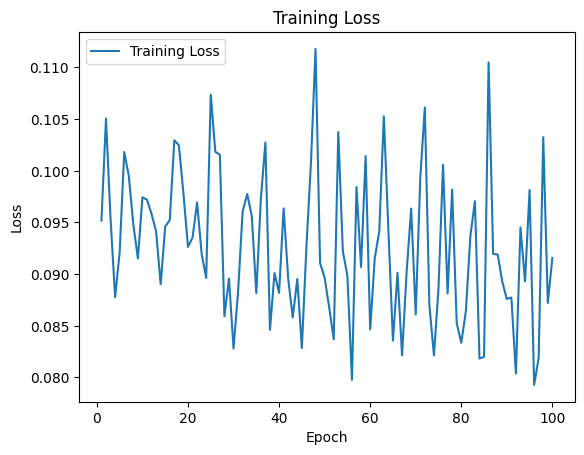

In [48]:
if train_loop_enable:
    train_losses = []
    num_samples = len(train_loader.dataset)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        # for inputs, labels in train_loader:        
        for inputs, labels, timesteps in train_loader:#--------------------------------
            # inputs, labels = inputs.to(device), labels.to(device)            
            inputs, labels, timesteps = inputs.to(device), labels.to(device), timesteps.to(device)#--------------------------------
            
            # Convert labels to index form
            labels = label_to_index(labels).to(device)
            # Forward pass
            outputs = model(inputs)  # Shape: [batch_size, sequence_length, num_classes]
            
            # Flatten time and batch dimensions for both outputs and labels
            loss = criterion(outputs.view(-1, num_classes), labels.view(-1))  # Flattened to compute loss
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # Calculate and store average loss for the epoch
        train_losses.append(running_loss / (num_samples / batch_size))
        
        if (epoch + 1) % 10 == 0:
            torch.save(model.state_dict(), model_file_path)
            print(f'Model saved: {model_file_path}')
        
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    print('Training finished!')

    # Plot training loss
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


Results forder make dir
---



In [15]:
results_dir = os.path.join(base_dir, "v3")
os.makedirs(results_dir, exist_ok=True)  # Tạo thư mục nếu chưa tồn tại


Result evaluation
---



In [49]:
import os
import torch.utils.data as data
from collections import defaultdict, Counter
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

# Initialize variables
TP, number_sample = 0, 0
wrong_predictions = defaultdict(lambda: {"predicted_labels": [], "timesteps": [], "count": 0})
TP_dict, FP_dict, FN_dict, total_samples_per_label = defaultdict(int), defaultdict(int), defaultdict(int), defaultdict(int)
all_true_labels, all_predicted_labels, all_timesteps = [], [], []

# Evaluate model
model.eval()
with torch.no_grad():
    for input_sequence, label, timesteps in test_loader:  # Include timesteps
        input_sequence = input_sequence.to(device)
        label = label.to(device)
        timesteps = timesteps.to(device)

        # Forward pass
        output = model(input_sequence)  # Shape: [batch_size, sequence_length, num_classes]

        # Get predicted classes for each timestep
        predicted_class = torch.argmax(output, dim=2)  # Shape: [batch_size, sequence_length]
        

        number_sample += label.size(0) * label.size(1)  # Total number of labels

        for i in range(label.size(0)):  # Iterate over each sample in the batch
            true_sequence = label[i]
            predicted_sequence = predicted_class[i]
            timestep_sequence = timesteps[i]
            # print(timestep_sequence)

            for t in range(label.size(1)):  # Iterate over each timestep
                true_label = true_sequence[t].item()
                predicted_label = index_to_label_func(predicted_sequence[t].item())  # Convert predicted class index to original label
                timestep = timestep_sequence[t].item()
                # print(timestep)

                total_samples_per_label[true_label] += 1
                all_true_labels.append(true_label)
                all_predicted_labels.append(predicted_label)
                all_timesteps.append(timestep)

                if true_label == predicted_label:
                    TP += 1
                    TP_dict[true_label] += 1
                else:
                    FP_dict[predicted_label] += 1
                    FN_dict[true_label] += 1
                    wrong_predictions[true_label]["predicted_labels"].append(predicted_label)
                    wrong_predictions[true_label]["timesteps"].append(timestep)
                    wrong_predictions[true_label]["count"] += 1

# Calculate accuracy
accuracy = TP / number_sample * 100
print(f'Accuracy: {accuracy:.2f}%')

# Save all predictions
predictions_file = os.path.join(results_dir, "predictions.csv")
predictions_df = pd.DataFrame({
    "True Label": all_true_labels,
    "Predicted Label": all_predicted_labels,
    "Timestep": all_timesteps
})
predictions_df.to_csv(predictions_file, index=False)
print(f"Saved all predictions to {predictions_file}")

# Save wrong predictions
wrong_predictions_file = os.path.join(results_dir, "wrong_predictions.csv")
wrong_predictions_list = []
for true_label, details in wrong_predictions.items():
    for predicted_label, timestep in zip(details["predicted_labels"], details["timesteps"]):
        wrong_predictions_list.append({
            "True Label": true_label,
            "Predicted Label": predicted_label,
            "Timestep": timestep
        })

if wrong_predictions_list:
    wrong_predictions_df = pd.DataFrame(wrong_predictions_list)
    wrong_predictions_df.to_csv(wrong_predictions_file, index=False)
    print(f"Saved wrong predictions to {wrong_predictions_file}")
else:
    print("No wrong predictions to save.")

# Print classification metrics
precision_dict, recall_dict, f1_dict = {}, {}, {}
for label in TP_dict.keys():
    TP = TP_dict[label]
    FP = FP_dict[label]
    FN = FN_dict[label]
    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    precision_dict[label] = precision
    recall_dict[label] = recall
    f1_dict[label] = f1_score

    print(f"Label {label}:")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall: {recall:.2f}")
    print(f"  F1 Score: {f1_score:.2f}")

# Calculate macro F1 score
all_labels = set(TP_dict.keys()).union(set(FP_dict.keys())).union(set(FN_dict.keys()))
macro_f1_score = sum(f1_dict[label] for label in all_labels) / len(all_labels)
print('Mean macro F1 score:', macro_f1_score)

# Calculate Kappa
conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)

# Calculate observed agreement (p_o)
total_samples = np.sum(conf_matrix)
p_o = np.trace(conf_matrix) / total_samples

# Calculate expected agreement (p_e)
sum_true = np.sum(conf_matrix, axis=1)
sum_pred = np.sum(conf_matrix, axis=0)
p_e = np.sum(sum_true * sum_pred) / (total_samples ** 2)

# Calculate Kappa
kappa = (p_o - p_e) / (1 - p_e)
print("Kappa score:", kappa)

# Print labels with the most wrong predictions
print("Labels with most wrong predictions:")
sorted_wrong_predictions = sorted(wrong_predictions.items(), key=lambda x: x[1]["count"], reverse=True)
for label, details in sorted_wrong_predictions[:5]:  # Show top 5
    print(f"  Label {label}:")
    for predicted_label, count in Counter(details["predicted_labels"]).items():
        print(f"    Predicted as {predicted_label}: {count} times")


Accuracy: 85.42%
Saved all predictions to ./mung_data/1812\v3\predictions.csv
Saved wrong predictions to ./mung_data/1812\v3\wrong_predictions.csv
Label 84:
  Precision: 0.89
  Recall: 0.86
  F1 Score: 0.87
Label 34:
  Precision: 0.86
  Recall: 0.84
  F1 Score: 0.85
Label 43:
  Precision: 0.86
  Recall: 0.85
  F1 Score: 0.85
Label 53:
  Precision: 0.86
  Recall: 0.84
  F1 Score: 0.85
Label 74:
  Precision: 0.88
  Recall: 0.76
  F1 Score: 0.82
Label 33:
  Precision: 0.83
  Recall: 0.88
  F1 Score: 0.86
Label 32:
  Precision: 0.84
  Recall: 0.85
  F1 Score: 0.84
Label 12:
  Precision: 0.76
  Recall: 0.90
  F1 Score: 0.83
Label 23:
  Precision: 0.86
  Recall: 0.87
  F1 Score: 0.86
Label 94:
  Precision: 0.78
  Recall: 0.84
  F1 Score: 0.81
Label 93:
  Precision: 0.88
  Recall: 0.82
  F1 Score: 0.85
Label 41:
  Precision: 0.90
  Recall: 0.88
  F1 Score: 0.89
Label 31:
  Precision: 0.83
  Recall: 0.87
  F1 Score: 0.85
Label 82:
  Precision: 0.89
  Recall: 0.93
  F1 Score: 0.91
Label 14:
  P

Function for process testdata
---



In [26]:
# ______________________________Sec1____________________________________________
def calculate_area(signal, threshold=2.05):
    # Tính phần diện tích dưới đường cong và trục y=threshold
    diff_signal = signal - threshold

    # Tính diện tích sử dụng quy tắc hình thang
    area = torch.sum(torch.abs((diff_signal[:, :-1] + diff_signal[:, 1:]) / 2), dim=1)

    return area

def check_area(signals, threshold=0, area_threshold=1.5):
    # Tính diện tích cho từng sensor
    areas = calculate_area(signals, threshold)

    # # In ra diện tích của từng sensor
    # for i, area in enumerate(areas):
    #     print(f"Diện tích của sensor {i + 1}: {area.item()}")

    # Tính tổng diện tích của 5 sensor
    total_area = torch.sum(areas)
    # print(f"Tổng diện tích: {total_area.item()}")

    # Kiểm tra tổng diện tích có lớn hơn area_threshold không
    return total_area > area_threshold

# # Giả sử tín hiệu đầu vào dạng torch size (1,5,10)
# signals_list = [
#     [2.05,2.05,2.05,2.05,2.03,2.04,2.04,2.04,2.05,2.05],
#     [2.05,2.05,2.06,2.06,2.06,2.08,2.07,2.07,2.07,2.07],
#     [2.05,2.04,2.03,2.05,2.04,2.04,2.04,2.05,2.05,2.05],
#     [2.04,2.04,2.04,2.05,2.07,2.05,2.05,2.05,2.06,2.05],
#     [2.07,2.06,2.05,2.05,2.04,2.06,2.05,2.06,2.06,2.06]
# ]

# # Chuyển đổi signals_list thành tensor PyTorch
# signals = torch.tensor(signals_list, dtype=torch.float32)
# print(signals)
# # Kiểm tra diện tích
# result = check_area(signals)
# print(f"Kết quả: {result}")
# ______________________________Sec2____________________________________________
# Define the area
area = [
    [11, 12, 21, 22, 31, 32],
    [13, 14, 23, 24, 33, 34],
    [41, 42, 51, 52, 61, 62],
    [43, 44, 53, 54, 63, 64],
    [71, 72, 81, 82, 91, 92],
    [73, 74, 83, 84, 93, 94]
]
def string_labels_to_int(labels):
    """Convert a list of string labels to integer labels."""
    return [int(label) for label in labels]
def label_to_coords(label, area):
    """Convert label to coordinates in the custom grid system."""
    if label == 0:
        return None
    for i, row in enumerate(area):
        if label in row:
            row_index = i
            col_index = row.index(label)
            return (row_index, col_index)
    return None

def is_adjacent(coord1, coord2):
    """Check if two coordinates are adjacent in the 3x3 grid."""
    if coord1 is None or coord2 is None:
        return False
    row_diff = abs(coord1[0] - coord2[0])
    col_diff = abs(coord1[1] - coord2[1])
    return row_diff <= 1 and col_diff <= 1

def correct_labels_old(labels, area):
    """Correct the sequence of labels if they are not adjacent."""
    corrected_labels = []
    previous_coords = None
    i=0
    for label in labels:
        current_coords = label_to_coords(label, area)
        if label != 0 and previous_coords is not None and not is_adjacent(previous_coords, current_coords):
            corrected_labels.append(corrected_labels[-1])  # Use the last valid non-zero label
        else:
            corrected_labels.append(label)
        if label != 0:
            previous_coords = label_to_coords(corrected_labels[-1],area)
        i+=1

    return corrected_labels
def correct_labels(labels, area):
    """Correct the sequence of labels if they are not adjacent."""
    corrected_labels = labels.copy()
    previous_coords = None

    # First pass: fix non-adjacent labels
    for i, label in enumerate(labels):
        if label == 0:
            continue

        current_coords = label_to_coords(label, area)
        if previous_coords and not is_adjacent(previous_coords, current_coords):
            corrected_labels[i] = corrected_labels[i-1]
        previous_coords = current_coords if label != 0 else previous_coords
    # print(corrected_labels)
    # Second pass: handle zeros
    n = len(labels)
    i = 0
    # print(i)
    while i < n:
        if labels[i] == 0:
            # Find the start and end of the zero block
            start = i
            while i < n and labels[i] == 0:
                i += 1
            end = i - 1
            # print('bat dau 0 ket thuc: ',start,end)
            # print(corrected_labels)
            # Check the labels at the boundaries
            if start > 0 and end < n - 1:
                j=start-1
                k=end+1
                if labels[j] != labels[k]:
                    if labels[j] == labels[k+1]:
                        corrected_labels[k] = 0
                        continue
                    if labels[j-1] == labels[k]:
                        corrected_labels[j] = 0
                        continue
                    corrected_labels[j] = 0
                    corrected_labels[k] = 0
                    # print('thay',start-1,'-',end+1)
                    # Expand the zero block if necessary
                    j-=1
                    k+=1
                    while j > 0 and k < n - 1 and corrected_labels[j] != corrected_labels[k]:
                        if labels[j] == labels[k+1]:
                            corrected_labels[k] = 0
                            break
                        if labels[j-1] == labels[k]:
                            corrected_labels[j] = 0
                            break
                        corrected_labels[j] = 0
                        corrected_labels[k] = 0
                        j -= 1
                        k += 1
        i += 1

    return corrected_labels
def most_frequent_in_sliding_window(arr, k, s, padding):
    from collections import Counter

    # Kiểm tra các tham số đầu vào
    if not arr or k <= 0 or s <= 0:
        return []

    result = []
    n = len(arr)

    for i in range(0, n, s):
        # Tạo cửa sổ với padding nếu vượt quá giới hạn của danh sách
        if i<k//2:
            window = arr[0:i + k- k//2]
        else:
            window = arr[i-k//2:i + k- k//2]
            window = arr[i-k//2:i + k- k//2]
            if len(window) < k:
                if padding==None:
                    continue
                else:
                    window += [padding] * (k - len(window))

        if all(x == 0 for x in window):
            result.append(0)
        else:
            window=[x for x in window if x != 0]
            counter = Counter(window)
    
            # Tìm tần suất lớn nhất
            max_freq = max(counter.values())
    
            # Tìm phần tử xuất hiện nhiều nhất với tần suất max_freq, ưu tiên phần tử xuất hiện trước
            for num in window:
                if counter[num] == max_freq:
                    result.append(num)
                    break
        
    return result

def repeat_labels(labels, repeat_count=10, last_count=None):
    """Repeat each label in the list a specified number of times.

    Args:
    labels (list): List of labels to be repeated.
    repeat_count (int): Number of times to repeat each label.
    last_count (int): Number of times to repeat the last label. If None, use repeat_count for the last label as well.

    Returns:
    list: List of repeated labels.
    """
    if last_count is None:
        last_count = repeat_count

    repeated_labels = []
    for i, label in enumerate(labels):
        if i == len(labels) - 1:
            repeated_labels.extend([label] * last_count)
        else:
            repeated_labels.extend([label] * repeat_count)

    return repeated_labels

def process_labels(correct_labels):
    """Process labels by replacing 0 with the last non-zero label."""
    processed_labels = []
    waiting_zero = 0

    for label in correct_labels:
        if label == 0:
            if len(processed_labels) > 0 and processed_labels[-1] != 0:
                processed_labels.append(processed_labels[-1])
            else:
                waiting_zero += 1
        else:
            if waiting_zero > 0:
                processed_labels.extend([label] * (waiting_zero + 1))
                waiting_zero = 0
            else:
                processed_labels.append(label)
    return processed_labels
# # Example usage:
# corrected_labels = ['11', '12', '24', '33', 0, '44', '55', '66']  # Example corrected labels
# repeated_labels = repeat_labels(corrected_labels, repeat_count=10)
# print(repeated_labels)

# ______________________________Sec3____________________________________________
# Khu vực chứa các nhãn
area = [
    [11, 12, 21, 22, 31, 32],
    [13, 14, 23, 24, 33, 34],
    [41, 42, 51, 52, 61, 62],
    [43, 44, 53, 54, 63, 64],
    [71, 72, 81, 82, 91, 92],
    [73, 74, 83, 84, 93, 94]
]

# Hàm chuyển đổi từ nhãn sang tọa độ (x, y) dựa trên area
def label_to_xy(label, area):
    for i, row in enumerate(area):
        for j, cell in enumerate(row):
            if cell == label:
                return j - 2.5, 2.5 - i  # Return (x, y) coordinates
########################################################################################################################################                
# Hàm chuyển đổi từ nhãn sang tọa độ (x, y) dựa trên area
def label_to_xy(label, area):
    # Duyệt qua từng hàng và cột trong area
    for i, row in enumerate(area):
        for j, cell in enumerate(row):
            if cell == label:
                # Tọa độ x tăng từ trái sang phải, cách nhau 0.5
                x = j * 0.5 + 0.25
                # Tọa độ y tăng từ dưới lên trên, cách nhau 0.5
                y = (len(area) - i - 1) * 0.5 + 0.25
                return x, y
    # Nếu không tìm thấy nhãn, trả về None
    return None

# Hàm tính toán tọa độ trung bình của các điểm
def average_coordinates(coords):
    avg_x = sum(coord[0] for coord in coords) / len(coords)
    avg_y = sum(coord[1] for coord in coords) / len(coords)
    return avg_x, avg_y

# Hàm tính toán tọa độ trung bình của mỗi nhóm k điểm
def compute_group_coordinates(labels, area, k):
    new_coordinates = []
    for i in range(0, len(labels), k):  # Lặp qua các nhóm k nhãn
        coords = [label_to_xy(label, area) for label in labels[i:i+k]]  # Chuyển đổi nhãn thành tọa độ
        avg_coord = average_coordinates(coords)  # Tính toán tọa độ trung bình
        new_coordinates.append(avg_coord)  # Thêm tọa độ trung bình vào danh sách mới
    return new_coordinates

# Hàm vẽ đường đi từ danh sách tọa độ
def plot_path(coordinates):
    # Tách tọa độ x và y từ danh sách tọa độ
    x_coords, y_coords = zip(*coordinates)
    
    # Vẽ đường đi
    plt.plot(x_coords, y_coords, marker='o', linestyle='-')
    
    # Đặt tiêu đề và nhãn trục
    plt.title('Đường đi')
    plt.xlabel('Tọa độ x')
    plt.ylabel('Tọa độ y')
    
    # Hiển thị đồ thị
    plt.grid(True)
    plt.show()
    
# Hàm vẽ đường đi từ danh sách tọa độ
def mul_plot_path(coordinates,path="./plot.png"):
    if not coordinates:
        print("Danh sách tọa độ trống!")
        return
    
    # Kiểm tra xem có một hoặc nhiều xâu tọa độ
    if isinstance(coordinates[0], tuple):
        coordinates = [coordinates]  # Nếu chỉ có một xâu tọa độ, chuyển đổi thành danh sách có một phần tử
        
    # Lặp qua từng xâu tọa độ và vẽ
    for i, coord_set in enumerate(coordinates):
        # Tách tọa độ x và y từ danh sách tọa độ
        x_coords, y_coords = zip(*coord_set)
        
        # Vẽ đường đi với màu khác nhau cho mỗi xâu tọa độ
        plt.plot(x_coords, y_coords, marker='o', linestyle='-', alpha=0.5, label=f'Path {i+1}')
    
    # Đặt tiêu đề và nhãn trục
    plt.title('Đường đi')
    plt.xlabel('Tọa độ x')
    plt.ylabel('Tọa độ y')
    
    # Hiển thị đồ thị và chú thích
    plt.legend()
    plt.grid(True)
    plt.axis([-3,3,-3,3])
    
    # Lưu đồ thị vào thư mục /plots với tên file tương ứng
    plt.tight_layout()  # Tự động điều chỉnh khoảng cách giữa các subplot
    plt.savefig(path)

    plt.show()
######################################################################################################################################
# Khu vực chứa các nhãn
area = [
    [11, 12, 21, 22, 31, 32],
    [13, 14, 23, 24, 33, 34],
    [41, 42, 51, 52, 61, 62],
    [43, 44, 53, 54, 63, 64],
    [71, 72, 81, 82, 91, 92],
    [73, 74, 83, 84, 93, 94]
]

# Hàm chuyển đổi từ nhãn sang tọa độ (x, y) dựa trên area

# Danh sách màu sắc
colors = ['red', 'blue', 'yellow', 'green', 'orange', 'purple', 'cyan', 'magenta']
# Hàm vẽ từng điểm từ danh sách tọa độ
def mul_plot_points(coordinates):
    if not coordinates:
        print("Danh sách tọa độ trống!")
        return

    # Kiểm tra xem có một hoặc nhiều xâu tọa độ
    if isinstance(coordinates[0], tuple):
        coordinates = [coordinates]  # Nếu chỉ có một xâu tọa độ, chuyển đổi thành danh sách có một phần tử

    # Lặp qua từng xâu tọa độ và vẽ từng điểm
    for i, coord_set in enumerate(coordinates):
        # Tách tọa độ x và y từ danh sách tọa độ
        x_coords, y_coords = zip(*coord_set)

        # Chọn màu dựa trên chỉ số
        color = colors[i % len(colors)]  # Sử dụng modulo để quay lại màu nếu có nhiều hơn số màu

        # Vẽ các điểm với màu khác nhau cho mỗi xâu tọa độ
        plt.scatter(x_coords, y_coords, s=10, c=color, marker='o', alpha=0.3, label=f'Points {i+1}')

    # Đặt tiêu đề và nhãn trục
    plt.title('Các điểm tọa độ')
    plt.xlabel('Tọa độ x')
    plt.ylabel('Tọa độ y')

    # Hiển thị đồ thị và chú thích
    plt.legend()
    plt.grid(True)
    plt.axis([0, 3, 0, 3])  # Bạn có thể thay đổi giới hạn trục nếu cần
    plt.show()


Import test data
---



In [17]:
import os
import numpy as np
import pandas as pd
import torch

# Đường dẫn thư mục chính
base_dir = "./mung_data/testcase1812"

padding_x = 0

batch_name = []

# Khởi tạo danh sách lưu dữ liệu từ các thư mục cấp 1
x_test = []
y_test = []

# Tạo danh sách các thư mục cấp 1
level_1_dirs = sorted([d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))])

for l1_idx, l1_dir in enumerate(level_1_dirs):
    l1_path = os.path.join(base_dir, l1_dir)
    print(f"Đang xử lý thư mục: {l1_dir}")
    
    # Duyệt qua các file CSV trong thư mục cấp 2
    csv_files = sorted([f for f in os.listdir(l1_path) if f.endswith(".csv")])
    for file in csv_files:
        file_path = os.path.join(l1_path, file)
        print(f"    Đang xử lý file CSV: {file}")
        
        # Đọc và xử lý file CSV
        try:
            data = pd.read_csv(file_path, header=None)
            if data.empty:
                print(f'file {file} trống bỏ qua')
                continue
            
            # Danh sách lưu dòng hợp lệ
            valid_x = []
            valid_y = []
            
            # Duyệt qua từng dòng của file
            for idx, row in data.iterrows():
                try:                        
                    # Lấy giá trị x và y từ dòng
                    x = row[1:6].values-1500 # 5 cột
                    y = row[6]  # Nhãn

                    # Chuyển đổi nhãn nếu cần
                    if isinstance(y, str) and y.startswith('id'):
                        try:
                            # Lấy phần số sau 'id'
                            num_part = int(y[2:])
                            if num_part != 0:
                                y = int(num_part)  # Chuyển thành số thực
                            else:
                                # print(f"    Nhãn 'id{num_part}' không hợp lệ, bỏ qua.")
                                continue
                        except ValueError:
                            print(f"    Nhãn '{y}' không thể chuyển đổi, bỏ qua.")
                            continue
                    
                    # Loại bỏ dòng nếu y vẫn không hợp lệ
                    if pd.isna(y):
                        print(f"    Dòng {idx} không hợp lệ, bỏ qua.")
                        continue

                    # Lưu dòng hợp lệ
                    valid_x.append(x)
                    valid_y.append(int(y))
                
                except Exception as e:
                    print(f"    Lỗi khi xử lý dòng {idx}: {e}")
            
            # Chuyển danh sách thành numpy array
            valid_x = np.array(valid_x).T
            valid_y = np.array(valid_y).T
            
            # Thêm vào danh sách cấp 2
            x_test.append(valid_x)
            y_test.append(valid_y)  # Đảm bảo y có 2 chiều (số dòng, 1)
        
        except Exception as e:
            print(f"Lỗi khi xử lý file {file_path}: {e}")

x_sc_list=[]
y_sc_list=[]

for i in range(len(x_test)):
    # Chuyển đổi sang PyTorch tensors
    # x = np.array(x_test[i], dtype=float)  # Đảm bảo tất cả phần tử là float v1
    x = np.array(noise_filter(x_test[i]), dtype=float)  # Đảm bảo tất cả phần tử là float v2
    y = np.array(y_test[i], dtype=float)  # Tương tự
    
    x_tensor_test = torch.tensor(x, dtype=torch.float32)  # Kích thước: (số lát cắt, step)
    y_tensor_test = torch.tensor(y, dtype=torch.float32)  # Kích thước: (số lát cắt, step)
    x_sc_list.append(x_tensor_test)
    y_sc_list.append(y_tensor_test)

Đang xử lý thư mục: testcase1
    Đang xử lý file CSV: 1734527778996-1734527810034.csv
    Đang xử lý file CSV: 1734527830628-1734527861884.csv
    Đang xử lý file CSV: 1734527870919-1734527902219.csv
Đang xử lý thư mục: testcase2
    Đang xử lý file CSV: 1734527923084-1734527957426.csv
    Đang xử lý file CSV: 1734527976733-1734528008005.csv
    Đang xử lý file CSV: 1734528017855-1734528053746.csv
Đang xử lý thư mục: testcase3
    Đang xử lý file CSV: 1734528075933-1734528118816.csv
    Đang xử lý file CSV: 1734528128955-1734528170679.csv
    Đang xử lý file CSV: 1734528182138-1734528224651.csv
Đang xử lý thư mục: testcase4
    Đang xử lý file CSV: 1734528248398-1734528289443.csv
    Đang xử lý file CSV: 1734528297002-1734528341248.csv
    Đang xử lý file CSV: 1734528353818-1734528395109.csv


In [10]:
x_sc_list[0]

tensor([[ -12.5447,  -12.1372,  -11.7197,  ...,  -25.3734,  -25.0725,
          -24.8188],
        [ -27.3237,  -28.3168,  -29.3208,  ..., -106.9589, -107.2145,
         -107.4251],
        [  -2.3524,   -2.6905,   -3.0050,  ...,    9.8828,   11.2053,
           12.3818],
        [ -22.8235,  -22.0326,  -21.2601,  ...,    1.7641,    0.7978,
           -0.1441],
        [ -27.1240,  -27.0690,  -27.0284,  ...,  -68.0191,  -68.5416,
          -69.0084]])

Predict and visual testdata (All scenarios)
---



Kịch bản 1
Data written to result compare/v3/ket_qua_test_v3/output_kich_ban_1.csv
Kappa score: 0.36204887476256564
Khoảng cách trung bình: 0.17069536084490222


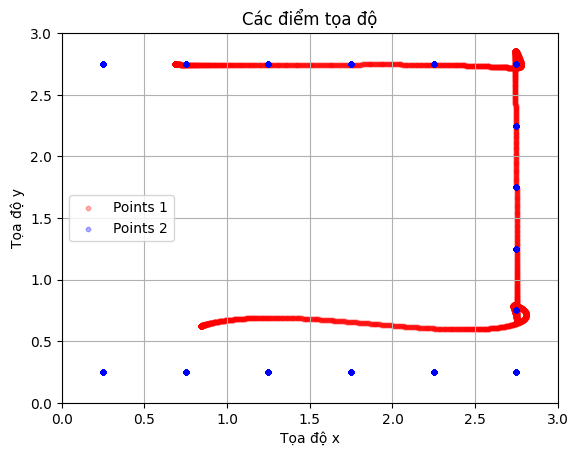

Kịch bản 2
Data written to result compare/v3/ket_qua_test_v3/output_kich_ban_2.csv
Kappa score: 0.4270513625826815
Khoảng cách trung bình: 0.15707822229281027


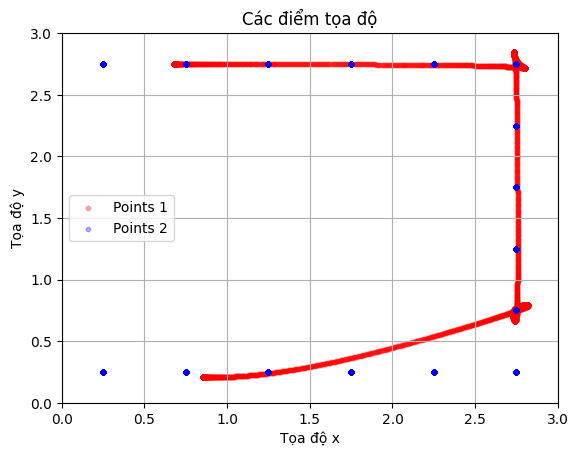

Kịch bản 3
Data written to result compare/v3/ket_qua_test_v3/output_kich_ban_3.csv
Kappa score: 0.4678816197988672
Khoảng cách trung bình: 0.14539215225803304


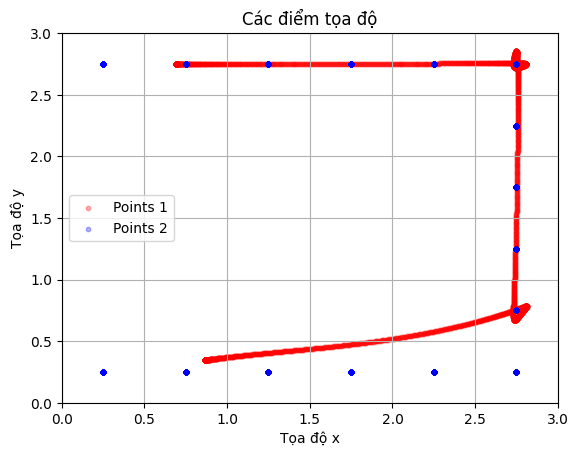

Kịch bản 4
Data written to result compare/v3/ket_qua_test_v3/output_kich_ban_4.csv
Kappa score: 0.720965016921086
Khoảng cách trung bình: 0.0825346550494149


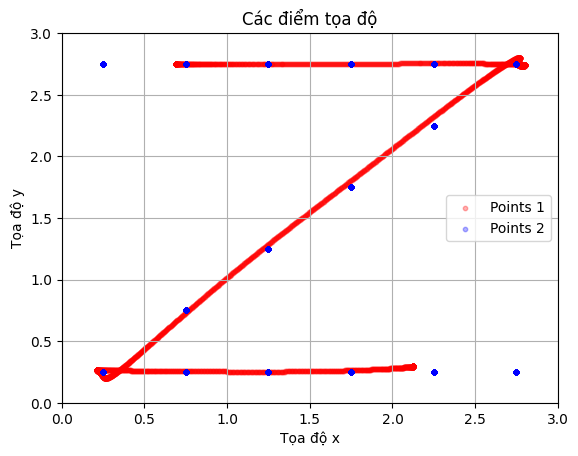

Kịch bản 5
Data written to result compare/v3/ket_qua_test_v3/output_kich_ban_5.csv
Kappa score: 0.45431441799320116
Khoảng cách trung bình: 0.2821011580103317


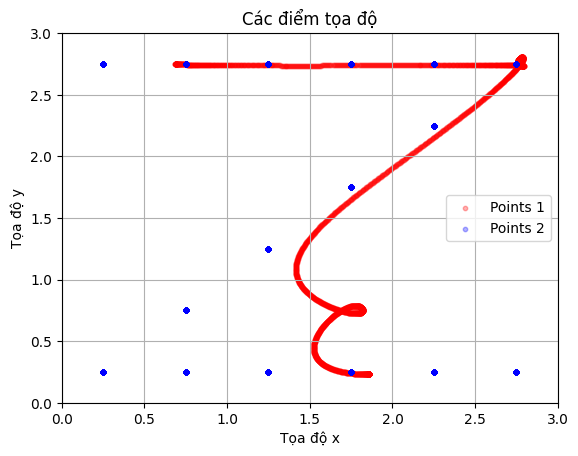

Kịch bản 6
Data written to result compare/v3/ket_qua_test_v3/output_kich_ban_6.csv
Kappa score: 0.19426513023954073
Khoảng cách trung bình: 0.5535807266428414


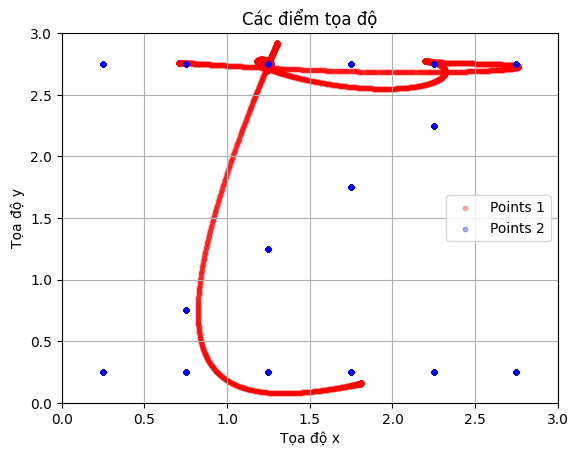

Kịch bản 7
Data written to result compare/v3/ket_qua_test_v3/output_kich_ban_7.csv
Kappa score: 0.4646449459104751
Khoảng cách trung bình: 0.16438081508922378


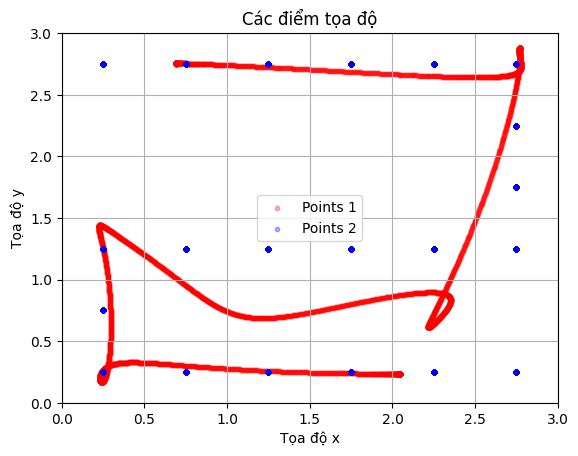

Kịch bản 8
Data written to result compare/v3/ket_qua_test_v3/output_kich_ban_8.csv
Kappa score: 0.6593372905191694
Khoảng cách trung bình: 0.12368484423132728


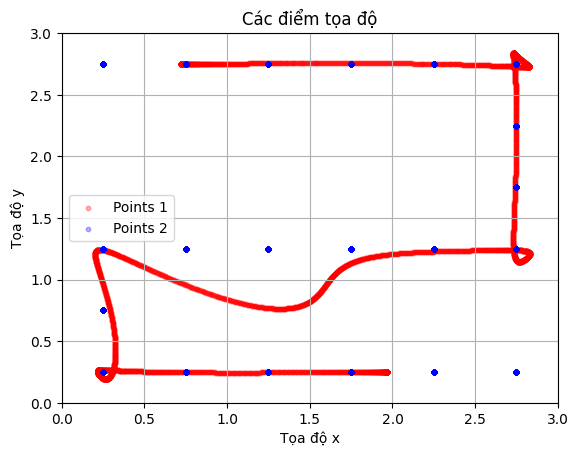

Kịch bản 9
Data written to result compare/v3/ket_qua_test_v3/output_kich_ban_9.csv
Kappa score: 0.7047211775198425
Khoảng cách trung bình: 0.11984296509812271


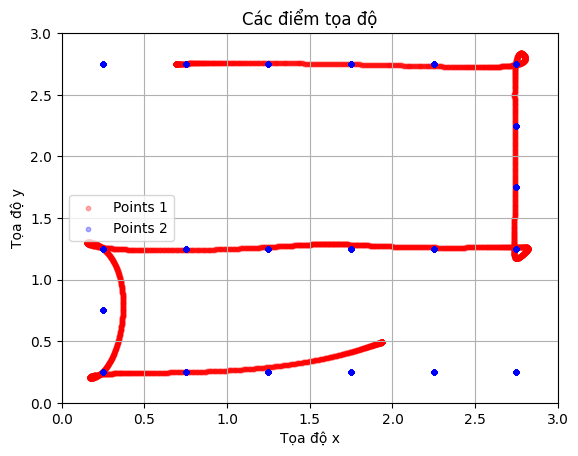

Kịch bản 10
Data written to result compare/v3/ket_qua_test_v3/output_kich_ban_10.csv
Kappa score: 0.46742678062084364
Khoảng cách trung bình: 0.183142408115931


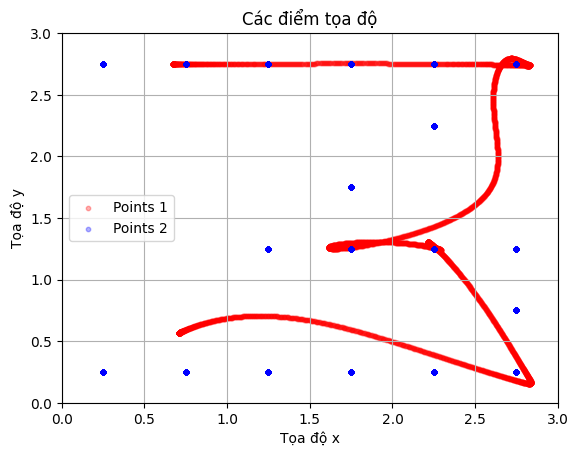

Kịch bản 11
Data written to result compare/v3/ket_qua_test_v3/output_kich_ban_11.csv
Kappa score: 0.448581192719018
Khoảng cách trung bình: 0.21066017513723798


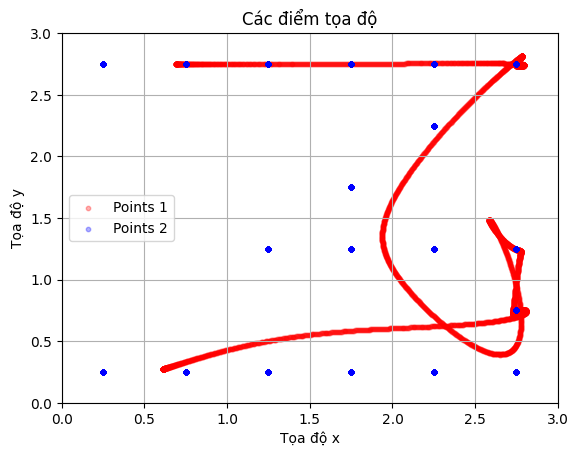

Kịch bản 12
Data written to result compare/v3/ket_qua_test_v3/output_kich_ban_12.csv
Kappa score: 0.34947015971753737
Khoảng cách trung bình: 0.2063353851972151


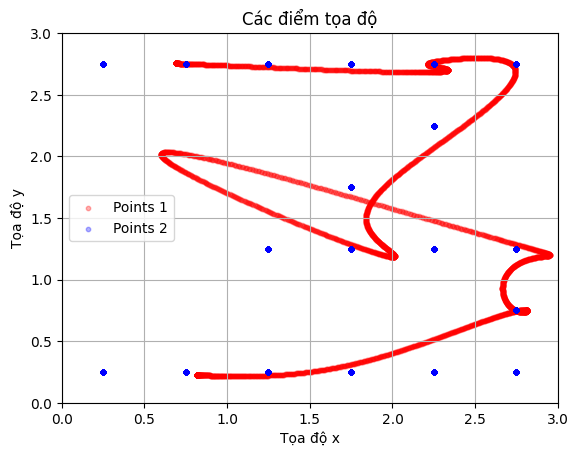

In [39]:
import pandas as pd
import torch
import numpy as np
from sklearn.metrics import cohen_kappa_score
import ast  # Thêm import ast nếu chưa có

window_size = sequence_length

# Chọn kịch bản
for sc_index in range(len(y_sc_list)):
    print('Kịch bản', sc_index + 1)
    X_test = x_sc_list[sc_index]
    Y_test = y_sc_list[sc_index]
    
    # Số lượng cửa sổ có thể tạo ra từ dữ liệu test
    num_windows = X_test.shape[1] // window_size  # Chia nguyên để đảm bảo num_windows là số nguyên
    window_residual = X_test.shape[1] % window_size
    if window_residual:
        num_windows += 1
    else:
        window_residual = window_size
    
    max_result = 0
    best_threshold =5000

#----------------------------------------------------------------------------------------------------------------------------------------------
    # for thre_i in range(50):
    #     # Lặp qua từng mẫu trong X_test và dự đoán nhãn cho từng cửa sổ
    #     predictions = []
    #     sample_windows = []
    #     sample=X_test
    #     for i in range(num_windows):
    #         window = sample[:, i * window_size: (i + 1) * window_size].unsqueeze(0)  # Chọn cửa sổ và thêm chiều batch_size
    #         check = check_area(window[0], area_threshold=thre_i)
    #         if check:
    #             model.eval()
    #             with torch.no_grad():  # Tắt gradient để tiết kiệm bộ nhớ và tính toán
    #                 output = model(window.to(device))  # Dự đoán nhãn cho cửa sổ hiện 

    #             # Xử lý đầu ra
    #             predicted_class = torch.argmax(output, dim=2).squeeze().tolist()  # Dự đoán cho từng bước thời gian
    #             predicted_label = [index_to_label_func(index) for index in predicted_class]
    #         else:
    #             predicted_label = [0] * window_size  # Tạo dự đoán mặc định nếu không kiểm tra thành công
            
    #         sample_windows.extend(predicted_label)  # Thêm tất cả các dự đoán vào danh sách
    #     predictions.append(sample_windows)
        
    #     # Chọn dự đoán cho cửa sổ đầu tiên
    #     prediction_raw=predictions[0]
    #     corrected_labels = correct_labels_old(prediction_raw, area)
    #     # processed_labels = process_labels(corrected_labels)
    #     processed_labels = process_labels(prediction_raw)
    #     int_list = [int(x) for x in Y_test.tolist()]
        

    #     true_case = 0
    #     if len(processed_labels)!=0:
    #         # Trim corrected_labels and processed_labels to the length of int_list
    #         min_length = len(prediction_raw)
    #         if len(prediction_raw)>len(int_list):
    #             min_length = len(int_list)
    #         for i in range(len(int_list)):
    #             if int_list[i] == processed_labels[i]:
    #                 true_case += 1
    #         accuracy = true_case / len(int_list)
            
    #         if accuracy > max_result:
    #             max_result = accuracy
    #             best_threshold = thre_i
        
    # print("\nĐộ chính xác tốt nhất:", max_result, '----- Best threshold:', best_threshold)
#----------------------------------------------------------------------------------------------------------------------------------------------
    # Dự đoán với threshold tốt nhất
    predictions = []
    sample_windows = []
    sample=X_test
    for i in range(num_windows):
        window = sample[:,i * window_size: (i + 1) * window_size].unsqueeze(0)
        check = check_area(window[0], area_threshold=best_threshold)
        if check:
            model.eval()
            with torch.no_grad():
                output = model(window.to(device))
            predicted_class = torch.argmax(output, dim=2).squeeze().tolist()
            predicted_label = [index_to_label_func(index) for index in predicted_class]
        else:
            predicted_label = [0] * window_size
        sample_windows.extend(predicted_label)
    predictions.append(sample_windows)

    prediction_raw=predictions[0]
    corrected_labels = correct_labels_old(prediction_raw, area)
    # corrected_labels=prediction_raw
    processed_labels = process_labels(corrected_labels)
    # processed_labels = process_labels(prediction_raw)
    # repeated_labels = processed_labels
    int_list = [int(x) for x in Y_test.tolist()]

    # Trim corrected_labels and processed_labels to the length of int_list
    min_length = len(prediction_raw)
    if len(prediction_raw)>len(int_list):
        min_length = len(int_list)
    trimmed_prediction_raw = prediction_raw[:min_length]
    trimmed_corrected_labels = corrected_labels[:min_length]
    trimmed_processed_labels = processed_labels[:min_length]
    int_list = int_list[:min_length]

#----------------------------------------------------------------------------------------------------------------------------------------------
    import os
    import csv
    
    # Specify the file path
    file_path = f'result compare/v3/ket_qua_test_v3/output_kich_ban_{sc_index+1}.csv'
    
    # Create the directory if it doesn't exist
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    # Open the file in write mode
    with open(file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        
        # Write the header
        writer.writerow(['Corrected Labels', 'Processed Labels', 'Ground', 'Raw'])
        
        # Write the data rows
        for c_label, p_label, i_val, r_val in zip(trimmed_corrected_labels, trimmed_processed_labels, int_list,trimmed_prediction_raw):
            # Include predictions[0] in each row
            writer.writerow([c_label, p_label, i_val, r_val])
    
    print(f"Data written to {file_path}")
    

    y_true_np = np.array(int_list)
    y_pred_np = np.array(trimmed_processed_labels)
    
    kappa = cohen_kappa_score(y_true_np, y_pred_np)
    print('Kappa score:', kappa)

    # Chuyển đổi các nhãn từ danh sách 1D sang danh sách tọa độ 2D (x, y)
    y_true_xy = compute_group_coordinates(int_list, area, k=1)
#----------------------------------------------------------------------------------------------------------------------------------------------
    best_len=1
    # best_dis=3
    # for i in range(1000):
    #     y_pred_xy = compute_group_coordinates(trimmed_processed_labels, area, k=i+1)
    #     repeated_y_pred_xy = repeat_labels(y_pred_xy, repeat_count=i+1, last_count=window_residual)
        
    #     # Tính khoảng cách trung bình (Mean Distance)
    #     distances = [np.linalg.norm(np.array(true_xy) - np.array(pred_xy)) for true_xy, pred_xy in zip(y_true_xy, repeated_y_pred_xy)]
    #     mean_distance = np.mean(distances)/2

    #     if best_dis>mean_distance:
    #         best_dis=mean_distance
    #         best_len=i+1
    # print(best_len)
#----------------------------------------------------------------------------------------------------------------------------------------------
    y_pred_xy = compute_group_coordinates(trimmed_processed_labels, area, k=best_len)
    repeated_y_pred_xy = repeat_labels(y_pred_xy, repeat_count=best_len, last_count=window_residual)
    repeated_y_pred_xy = noise_filter(np.array(repeated_y_pred_xy).T,100,0.2).T #loc nhieu thong thap
    
    # Tính khoảng cách trung bình (Mean Distance)
    distances = [np.linalg.norm(np.array(true_xy) - np.array(pred_xy)) for true_xy, pred_xy in zip(y_true_xy, repeated_y_pred_xy)]
    mean_distance = np.mean(distances)/2
    print("Khoảng cách trung bình:", mean_distance)
    
    path=f'result compare/v3/ket_qua_test_v3/output_kich_ban_{sc_index+1}.png'
    # Vẽ đường đi từ danh sách tọa độ
    # mul_plot_path([y_true_xy, repeated_y_pred_xy],path)
    mul_plot_points([repeated_y_pred_xy,y_true_xy])


# B

In [32]:
import torch.utils.data as data
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Initialize variables
TP, number_sample = 0, 0
wrong_predictions = defaultdict(lambda: {"predicted_labels": [], "count": 0})
TP_dict, FP_dict, FN_dict, total_samples_per_label = defaultdict(int), defaultdict(int), defaultdict(int), defaultdict(int)
all_true_labels, all_predicted_labels = [], []

# Evaluate model
model.eval()
with torch.no_grad():
    # for input_sequence, label in test_loader:
    for input_sequence, label, timesteps  in test_loader: #--------------------------------
        input_sequence = input_sequence.to(device)
        label = label.to(device)  # True labels are already sequences, shape [batch_size, sequence_length]
        timesteps = timesteps.to(device)#--------------------------------

        # Forward pass
        output = model(input_sequence)  # Shape: [batch_size, sequence_length, num_classes]

        # Get the predicted classes for each timestep
        predicted_class = torch.argmax(output, dim=2)  # Shape: [batch_size, sequence_length]

        number_sample += label.size(0) * label.size(1)  # Total number of labels (batch_size * sequence_length)

        for i in range(label.size(0)):  # Iterate over each sample in the batch
            true_sequence = label[i]  # True labels for the current sequence, shape [sequence_length]
            predicted_sequence = predicted_class[i]  # Predicted labels for the current sequence, shape [sequence_length]

            for t in range(label.size(1)):  # Iterate over each timestep
                true_label = true_sequence[t].item()  # Get true label for the current timestep
                predicted_label = index_to_label_func(predicted_sequence[t].item())  # Convert predicted class index to original label
                
                total_samples_per_label[true_label] += 1
                all_true_labels.append(true_label)
                all_predicted_labels.append(predicted_label)

                if true_label == predicted_label:
                    TP += 1
                    TP_dict[true_label] += 1
                else:
                    FP_dict[predicted_label] += 1
                    FN_dict[true_label] += 1
                    wrong_predictions[true_label]["predicted_labels"].append(predicted_label)
                    wrong_predictions[true_label]["count"] += 1

# Calculate accuracy
accuracy = TP / number_sample * 100
print(f'Accuracy: {accuracy:.2f}%')

# Calculate and print precision, recall, and F1 score for each label
precision_dict, recall_dict, f1_dict = {}, {}, {}
for label in TP_dict.keys():
    TP = TP_dict[label]
    FP = FP_dict[label]
    FN = FN_dict[label]
    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    precision_dict[label] = precision
    recall_dict[label] = recall
    f1_dict[label] = f1_score

    print(f"Label {label}:")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall: {recall:.2f}")
    print(f"  F1 Score: {f1_score:.2f}")

# Calculate mean macro F1 score
all_labels = set(TP_dict.keys()).union(set(FP_dict.keys())).union(set(FN_dict.keys()))
macro_f1_score = sum(
    (2 * (TP_dict[label] / (TP_dict[label] + FP_dict[label]) if (TP_dict[label] + FP_dict[label]) > 0 else 0) *
     (TP_dict[label] / (TP_dict[label] + FN_dict[label]) if (TP_dict[label] + FN_dict[label]) > 0 else 0)) /
    ((TP_dict[label] / (TP_dict[label] + FP_dict[label]) if (TP_dict[label] + FP_dict[label]) > 0 else 0) +
     (TP_dict[label] / (TP_dict[label] + FN_dict[label]) if (TP_dict[label] + FN_dict[label]) > 0 else 0)) if
    ((TP_dict[label] / (TP_dict[label] + FP_dict[label]) if (TP_dict[label] + FP_dict[label]) > 0 else 0) +
     (TP_dict[label] / (TP_dict[label] + FN_dict[label]) if (TP_dict[label] + FN_dict[label]) > 0 else 0)) > 0 else 0
    for label in all_labels
) / len(all_labels)
print('Mean macro F1 score', macro_f1_score)

# Calculate Kappa
conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)

# Calculate observed agreement (p_o)
total_samples = np.sum(conf_matrix)
p_o = np.trace(conf_matrix) / total_samples

# Calculate expected agreement (p_e)
sum_true = np.sum(conf_matrix, axis=1)
sum_pred = np.sum(conf_matrix, axis=0)
p_e = np.sum(sum_true * sum_pred) / (total_samples ** 2)

# Calculate Kappa
kappa = (p_o - p_e) / (1 - p_e)
print("Kappa score:", kappa)

# Print labels with the most wrong predictions
print("Labels with most wrong predictions:")
sorted_wrong_predictions = sorted(wrong_predictions.items(), key=lambda x: x[1]["count"], reverse=True)
for label, details in sorted_wrong_predictions[:5]:
    print(f"  Label {label}:")
    for predicted_label, count in Counter(details["predicted_labels"]).items():
        print(f"    Predicted as {predicted_label}: {count} times")

Accuracy: 77.18%
Label 82.0:
  Precision: 0.80
  Recall: 0.85
  F1 Score: 0.83
Label 34.0:
  Precision: 0.78
  Recall: 0.71
  F1 Score: 0.74
Label 11.0:
  Precision: 0.78
  Recall: 0.67
  F1 Score: 0.72
Label 64.0:
  Precision: 0.72
  Recall: 0.83
  F1 Score: 0.77
Label 21.0:
  Precision: 0.77
  Recall: 0.75
  F1 Score: 0.76
Label 41.0:
  Precision: 0.80
  Recall: 0.64
  F1 Score: 0.71
Label 54.0:
  Precision: 0.85
  Recall: 0.80
  F1 Score: 0.83
Label 31.0:
  Precision: 0.76
  Recall: 0.86
  F1 Score: 0.81
Label 94.0:
  Precision: 0.80
  Recall: 0.73
  F1 Score: 0.77
Label 33.0:
  Precision: 0.72
  Recall: 0.77
  F1 Score: 0.75
Label 63.0:
  Precision: 0.84
  Recall: 0.78
  F1 Score: 0.81
Label 43.0:
  Precision: 0.73
  Recall: 0.74
  F1 Score: 0.74
Label 44.0:
  Precision: 0.75
  Recall: 0.81
  F1 Score: 0.78
Label 92.0:
  Precision: 0.81
  Recall: 0.81
  F1 Score: 0.81
Label 61.0:
  Precision: 0.79
  Recall: 0.88
  F1 Score: 0.83
Label 53.0:
  Precision: 0.78
  Recall: 0.76
  F1 Sco

Kịch bản 8
115
Data written to ./output_kich_ban_8.csv
2309
Kappa score: 0.23024955403051073
Khoảng cách trung bình: 1.2349880181178727


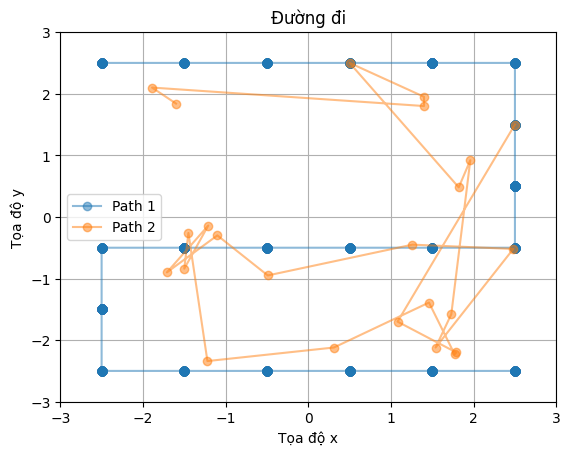

In [15]:


window_size = sequence_length
sc_index=7

print('Kịch bản', sc_index + 1)
X_test = x_sc_list[sc_index]
Y_test = y_sc_list[sc_index]

# Số lượng cửa sổ có thể tạo ra từ dữ liệu test
num_windows = X_test.shape[1] // window_size  # Chia nguyên để đảm bảo num_windows là số nguyên
print(num_windows)
window_residual = X_test.shape[1] % window_size
if window_residual:
    num_windows += 1
else:
    window_residual = window_size

max_result = 0
best_threshold = 0

# Dự đoán với threshold tốt nhất
predictions = []
sample_windows = []
sample=X_test
for i in range(num_windows):
    window = sample[:,i * window_size: (i + 1) * window_size].unsqueeze(0)
    check = check_area(window[0], area_threshold=best_threshold)
    if check:
        model.eval()
        with torch.no_grad():
            output = model(window.to(device))
        predicted_class = torch.argmax(output, dim=2).squeeze().tolist()
        predicted_label = [index_to_label_func(index) for index in predicted_class]
    else:
        predicted_label = [0] * window_size
    sample_windows.extend(predicted_label)
predictions.append(sample_windows)

prediction_raw=predictions[0]
# corrected_labels = correct_labels_old(prediction_raw, area)
corrected_labels = prediction_raw
processed_labels = process_labels(corrected_labels)
repeated_labels = processed_labels
# repeated_labels = predictions[0]

int_list = [int(x) for x in Y_test.tolist()]

# Trim corrected_labels and processed_labels to the length of int_list
min_length = len(prediction_raw)
if len(prediction_raw)>len(int_list):
    min_length = len(int_list)
trimmed_prediction_raw = prediction_raw[:min_length]
trimmed_corrected_labels = corrected_labels[:min_length]
trimmed_processed_labels = processed_labels[:min_length]
int_list = int_list[:min_length]

import os
import csv

# Specify the file path
file_path = f'./output_kich_ban_{sc_index+1}.csv'

# Create the directory if it doesn't exist
directory = os.path.dirname(file_path)
if not os.path.exists(directory):
    os.makedirs(directory)
    
# Open the file in write mode
with open(file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Write the header
    writer.writerow(['Corrected Labels', 'Processed Labels', 'Ground', 'Raw'])
    
    # Write the data rows
    for c_label, p_label, i_val, r_val in zip(trimmed_corrected_labels, trimmed_processed_labels, int_list,trimmed_prediction_raw):
        # Include predictions[0] in each row
        writer.writerow([c_label, p_label, i_val, r_val])

print(f"Data written to {file_path}")


print(len(int_list))
y_true_np = np.array(int_list)
y_pred_np = np.array(trimmed_processed_labels)

kappa = cohen_kappa_score(y_true_np, y_pred_np)
print('Kappa score:', kappa)

# Chuyển đổi các nhãn từ danh sách 1D sang danh sách tọa độ 2D (x, y)
y_true_xy = compute_group_coordinates(int_list, area, k=1)
y_pred_xy = compute_group_coordinates(repeated_labels, area, k=100)
repeated_y_pred_xy = repeat_labels(y_pred_xy, repeat_count=100, last_count=window_residual)

# Tính khoảng cách trung bình (Mean Distance)
distances = [np.linalg.norm(np.array(true_xy) - np.array(pred_xy)) for true_xy, pred_xy in zip(y_true_xy, repeated_y_pred_xy)]
mean_distance = np.mean(distances)/2

print("Khoảng cách trung bình:", mean_distance)

# Vẽ đường đi từ danh sách tọa độ
mul_plot_path([y_true_xy, y_pred_xy])
